In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler

import math

In [2]:
f = uproot.open('/Users/jshlomi/Desktop/Datasets/TruthTagging/datasetNewFormat_800k.root')

In [5]:
for key in f.keys():
    print(key)

b'h1dR0;1'
b'h1dR1;1'
b'h1dR2;1'
b'h1eta;1'
b'h1;1'
b't1;1'


In [6]:
for key in f['t1'].keys():
    print(key, f['t1'].array(key)[0])

b'jet_pt' [750.594     61.12262   45.023663]
b'jet_eta' [-0.44284642 -0.20170802  1.772796  ]
b'jet_phi' [-2.6190274  -1.2963486   0.92201716]
b'jet_label' [2 1 3]
b'jet_score' [0.58708245 0.36451545 0.79709184]
b'jet_eff' [0.15771769 0.9336995  0.02277992]
b'jet_tag' [0 1 0]
b'nJets' 3
b'mass' 268.26273


In [7]:
f['t1'].numentries

800000

In [8]:
f['t1'].pandas.df(['jet_pt','jet_eta','jet_phi','jet_label','jet_tag'],entrystart=10,entrystop=15).reset_index()

,entry,subentry,jet_pt,jet_eta,jet_phi,jet_label,jet_tag
0,10,0,388.419159,-0.219824,-0.299123,1,1
1,10,1,50.619904,-1.782675,-1.399243,3,0
2,10,2,33.118786,0.738623,-1.429117,1,1
3,11,0,218.037491,-1.452783,-1.907602,1,1
4,11,1,217.952530,1.250095,-0.812666,1,1
5,11,2,198.621689,-1.472275,0.589758,2,0
6,11,3,100.988602,1.275110,-2.963007,1,1
7,12,0,194.384262,1.711038,-2.475176,1,1
8,12,1,164.029663,0.918173,-0.471601,3,0
9,13,0,202.414612,1.209149,-1.553285,2,0


## split the dataset to training and validation sets

In [3]:
n_entries = f['t1'].numentries
training_split = 600000

def collect_jets(entrystart,entry_stop):
    df = f['t1'].pandas.df(['jet_pt','jet_eta','jet_phi','jet_label','jet_eff','jet_score'],
                           entrystart=entrystart,entrystop=entry_stop).reset_index()
    df['jet_tag'] = 1*(df.jet_score < df.jet_eff)
    return df

jets_train_data = collect_jets(0,training_split)
jet_valid_data = collect_jets(training_split,n_entries)

event_df_train = f['t1'].pandas.df(['mass'],entrystart=0,entrystop=training_split)
event_df_valid = f['t1'].pandas.df(['mass'],entrystart=training_split)

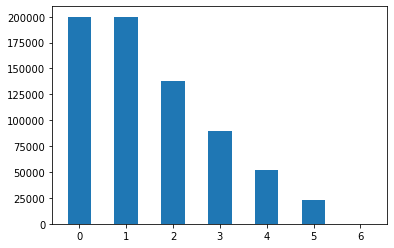

In [4]:
plt.hist(jet_valid_data['subentry'],bins=np.linspace(-0.25,6.25,14));

## compute the dR and flavor of each nearby jet

In [5]:
import itertools

def deltaphi(x):
    
    
    while len(np.where(x >= np.pi)[0]) > 0:
        x[np.where(x >= np.pi)[0]] -= 2*np.pi;
    while len(np.where(x < -np.pi)[0]) > 0: 
        x[np.where(x < -np.pi)[0]]+= 2*np.pi
    return x;

def deltaR(eta,phi,eta2,phi2):
    deta = eta-eta2
    dphi = deltaphi(phi-phi2)
    return np.sqrt( deta*deta+dphi*dphi )

def compute_dRs(df):
    event_numbers = list(set(df['entry'].values))
    n_events = len(event_numbers)
    min_event = np.amin(event_numbers)
        
    n_jets_per_event = np.histogram( df.entry.values ,
                                        bins=np.linspace(-0.5+min_event,min_event+n_events+0.5-1,n_events+1))[0]
    
    total_jets = len(df)
    #print('total ',total_jets)
    splitindices = []
    running_sum = 0
    event_sum = 0
    combinations = []
    jet_n_neighbors = []
    for n_jets in n_jets_per_event:
        
        for _ in range(n_jets):
            jet_n_neighbors.append((n_jets-1))
            splitindices.append( (n_jets-1)+running_sum)
            running_sum+=(n_jets-1)
        comb = np.array(list(itertools.product(np.arange(n_jets), repeat=2)))

        combinations.append( comb+event_sum )
        
        event_sum+=n_jets
    
    
    combinations = np.concatenate(combinations)

    eta1 = df.jet_eta.values[combinations[:,0]]
    phi1 = df.jet_phi.values[combinations[:,0]]
    
    eta2 = df.jet_eta.values[combinations[:,1]]
    phi2 = df.jet_phi.values[combinations[:,1]]
    
    jet2_flavor = df.jet_label.values[combinations[:,1]]
    
    dRs = deltaR(eta1,phi1,eta2,phi2)
    jet2_flavor = jet2_flavor[dRs > 0]
    dRs = dRs[dRs > 0]
    dRs = np.split(dRs,splitindices)
    jet2_flavor = np.split(jet2_flavor,splitindices)
    
    
    
    return dRs[:-1],jet2_flavor[:-1],jet_n_neighbors


jets_train_data['dR'], jets_train_data['dR_flav'], jets_train_data['n_neighbors'] = compute_dRs(jets_train_data)
jet_valid_data['dR'], jet_valid_data['dR_flav'], jet_valid_data['n_neighbors'] = compute_dRs(jet_valid_data)

In [12]:
jets_train_data.head(10)

,entry,subentry,jet_pt,jet_eta,jet_phi,jet_label,jet_eff,jet_score,jet_tag,dR,dR_flav,n_neighbors
0,0,0,750.593994,-0.442846,-2.619027,2,0.157718,0.587082,0,"[1.3444802, 3.525395]","[1, 3]",2
1,0,1,61.122620,-0.201708,-1.296349,1,0.933699,0.364515,1,"[1.3444802, 2.969817]","[2, 3]",2
2,0,2,45.023663,1.772796,0.922017,3,0.022780,0.797092,0,"[3.525395, 2.969817]","[2, 1]",2
3,1,0,170.207855,-0.938059,-1.551244,3,0.023165,0.285708,0,"[0.8430556, 1.8412409]","[1, 3]",2
4,1,1,52.256104,-1.737792,-1.818019,1,0.677128,0.589427,1,"[0.8430556, 2.205813]","[3, 3]",2
5,1,2,50.610218,-1.072525,0.285081,3,0.021590,0.203992,0,"[1.8412409, 2.205813]","[3, 1]",2
6,2,0,50.938141,-0.796135,-0.453378,2,0.164551,0.036159,1,[0.2781897],[3],1
7,2,1,34.300751,-0.874236,-0.186377,3,0.014452,0.483142,0,[0.2781897],[2],1
8,3,0,192.808884,-0.314846,-0.606829,3,0.026291,0.140509,0,"[2.0900264, 1.694637, 2.0945754]","[2, 1, 1]",3
9,3,1,159.576340,1.766158,-0.412837,2,0.211216,0.265410,0,"[2.0900264, 0.9670957, 1.4734753]","[3, 1, 1]",3


## create a 2D (pt/eta) efficiency map from the training dataset

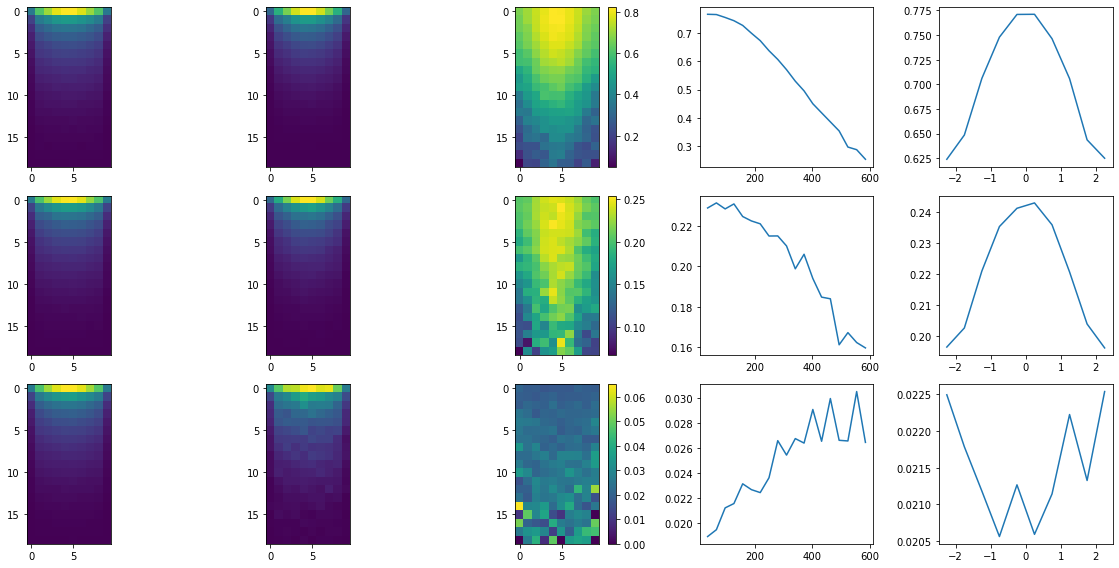

In [6]:
fig,ax = plt.subplots(3,5,figsize=(16,8))

eff_maps = {
    1: None,
    2: None,
    3: None,
}

for flav_i, flav in enumerate([1,2,3]):
    flav_cut = np.where(jets_train_data['jet_label']==flav)[0]
    
    pt_values = jets_train_data['jet_pt'].values[flav_cut]
    eta_values = jets_train_data['jet_eta'].values[flav_cut]
    istagged_values = jets_train_data['jet_tag'].values[flav_cut]

    pt_bins = np.linspace(20,600,20)
    eta_bins = np.linspace(-2.5,2.5,11)

    tagged_jets = np.where(istagged_values ==1)[0]
    total_histogram = np.histogram2d(pt_values,eta_values,bins=(pt_bins,eta_bins))
    pass_histogram = np.histogram2d(pt_values[tagged_jets],eta_values[tagged_jets],bins=(pt_bins,eta_bins))

    eff_map = np.divide(pass_histogram[0],total_histogram[0])

    ax[flav_i][0].imshow(total_histogram[0],aspect=1)
    ax[flav_i][1].imshow(pass_histogram[0],aspect=1)
    pos = ax[flav_i][2].imshow(eff_map,aspect=1)
    fig.colorbar(pos, ax=ax[flav_i][2])
    
    eff_maps[flav] = eff_map.copy()
    
    
    pt_projection = np.divide(pass_histogram[0].sum(axis=1),total_histogram[0].sum(axis=1))

    
    eta_projection = np.divide(pass_histogram[0].sum(axis=0),total_histogram[0].sum(axis=0))

    
    ax[flav_i][3].plot([0.5*(pt_bins[i+1]+pt_bins[i]) for i in range(len(pt_bins)-1)],pt_projection)
    ax[flav_i][4].plot([0.5*(eta_bins[i+1]+eta_bins[i]) for i in range(len(eta_bins)-1)],eta_projection)
plt.tight_layout()
plt.show()

## apply efficiency map to validation set and compute truth tag weights

In [7]:
def apply_effmaps(ds):

    pt_values = ds['jet_pt'].values
    eta_values = ds['jet_eta'].values

    results_effs = np.zeros(len(pt_values))

    for flav in [1,2,3]:
        flav_cut = np.where( ds['jet_label'].values==flav )[0]

        bins = [ 
                [np.min([x,len(pt_bins)-1])-1 for x in np.digitize(pt_values[flav_cut],pt_bins)],
              [np.min([x,len(eta_bins)-1])-1 for x in np.digitize(eta_values[flav_cut],eta_bins)] 
        ]

        effs = eff_maps[flav][tuple(bins)]

        results_effs[flav_cut] = effs

    
    ds['map_eff'] = results_effs

apply_effmaps(jet_valid_data)
apply_effmaps(jets_train_data)

In [8]:
effs_1 = jet_valid_data.loc[ jet_valid_data['subentry'] == 0 ]['map_eff'].values
effs_2 = jet_valid_data.loc[ jet_valid_data['subentry'] == 1 ]['map_eff'].values

tt_weights = {
 0: (1-effs_1)*(1-effs_2),
 1: (effs_1)*(1-effs_2)+(1-effs_1)*(effs_2),
 2: (effs_1)*(effs_2)
}



## compute direct tagging

In [9]:
jet_1_valid_target = jet_valid_data['jet_tag'].values[jet_valid_data['subentry']==0]
jet_2_valid_target = jet_valid_data['jet_tag'].values[jet_valid_data['subentry']==1]

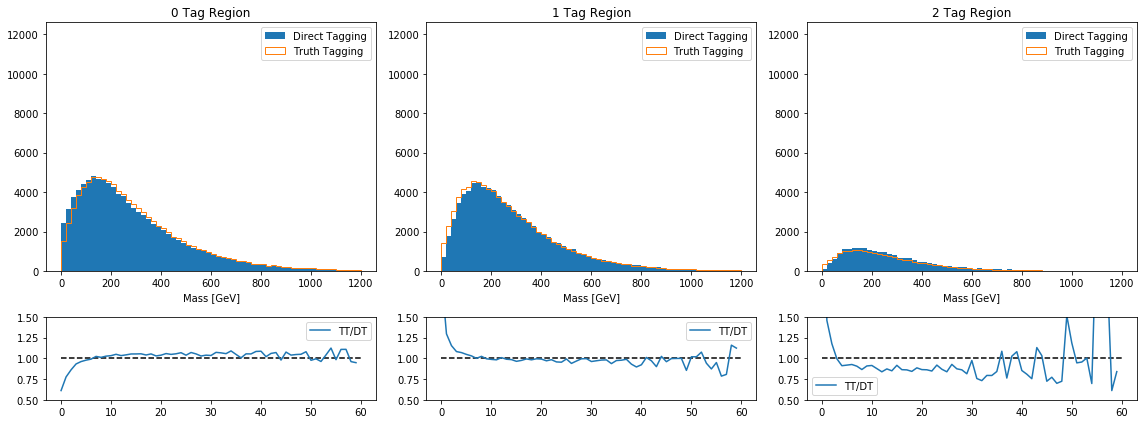

In [10]:
fig,ax = plt.subplots(2,3,figsize=(16,6),gridspec_kw={'height_ratios':[3,1]})



for plot_i, ntags in enumerate([0,1,2]):
    
    
    ax_i = ax[0][plot_i]
    
    if ntags==0:
        tag_condition = (jet_1_valid_target == 0) & (jet_2_valid_target == 0)
    elif ntags==1:
        tag_condition = (((jet_1_valid_target == 1) & (jet_2_valid_target == 0)) 
                         | ((jet_1_valid_target == 0) & (jet_2_valid_target == 1)) )
    elif ntags==2:
        tag_condition = (jet_1_valid_target == 1) & (jet_2_valid_target == 1)
    
    mass_binning = np.linspace(0,1200,61)
    h_dt = ax_i.hist(event_df_valid['mass'].values[tag_condition]
                     ,bins=mass_binning,label='Direct Tagging')
    h_tt = ax_i.hist(event_df_valid['mass'],weights=tt_weights[ntags],histtype='step',
              bins=mass_binning,
              label='Truth Tagging')
    
    ax[1][plot_i].plot([0,60],[1,1],color='k',linestyle='--')
    ax[1][plot_i].plot(h_tt[0]/h_dt[0],label='TT/DT')
    ax[1][plot_i].set_ylim(0.5,1.5)
    ax[1][plot_i].legend()
    ax_i.set_ylim(0,12600)
    ax_i.set_xlabel('Mass [GeV]')
    ax_i.set_title(str(ntags)+' Tag Region')
    ax_i.legend()
plt.tight_layout()
plt.show()

## create a neural network and train it

# we need to normalize the input variables

In [11]:
var_transformations = {}
for var_i,var  in enumerate(['jet_pt','jet_eta','jet_phi']):
    var_values = jets_train_data[var].values
    var_transformations[var] = [np.mean(var_values),np.std(var_values)]


## also normalize the dR values

In [12]:
dR_values = np.concatenate(jets_train_data['dR'].values)
var_transformations['dR'] = [np.mean(dR_values),np.std(dR_values)]

In [13]:
var_transformations

{'jet_pt': [129.75604, 111.821075],
 'jet_eta': [0.00034641812, 1.2283593],
 'jet_phi': [-0.71040446, 1.444804],
 'dR': [1.9601413, 0.9013492]}

## Create Dataset objects to handle loading and batching

In [14]:
class SingleJetDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy()
        
        
        self.n_jets = len(self.df)
        
        self.n_neighbors = self.df.n_neighbors
    
        for col in ['jet_pt','jet_eta','jet_phi']:
            mean, std = var_transformations[col]
            self.df[col] = (self.df[col].values-mean)/std
        
        drmean,dr_std = var_transformations['dR']
        
        self.dRs = (self.df['dR'].values-drmean)/dr_std
        self.flavs = self.df['dR_flav'].values
        
        self.xs = self.df[['jet_pt','jet_eta','jet_phi','jet_label']].values

        self.ys = self.df.jet_tag.values

    def __len__(self):
       
        return self.n_jets


    def __getitem__(self, idx):
        
        x = torch.FloatTensor(self.xs[idx])
        
        neighbor_block = torch.FloatTensor( np.column_stack((self.dRs[idx],self.flavs[idx]) ))
        y = torch.FloatTensor([self.ys[idx]])


        return x, neighbor_block, y

## create a seperate dataset for each flavor

In [15]:
b_jet_ds = SingleJetDataset(jets_train_data[jets_train_data.jet_label==1])
c_jet_ds = SingleJetDataset(jets_train_data[jets_train_data.jet_label==2])
u_jet_ds = SingleJetDataset(jets_train_data[jets_train_data.jet_label==3])

In [42]:
print(len(b_jet_ds), len(c_jet_ds),len(u_jet_ds))

701844 703011 703230


In [44]:
jet_ds[3]

(tensor([ 0.3618, -0.7640, -0.5820,  3.0000]), tensor([[-1.2393,  1.0000],
         [-0.1319,  3.0000]]), tensor([0.]))

In [16]:
class JetEventsSampler(Sampler):
    def __init__(self, n_nodes_array, batch_size):
        """
        Initialization
        :param n_nodes_array: array of sizes of the events
        """
        super().__init__(n_nodes_array.size)

        self.dataset_size = n_nodes_array.size
        self.batch_size = batch_size

        self.index_to_batch = {}
        self.node_size_idx = {}
        running_idx = -1

        for n_nodes_i in set(n_nodes_array):

            self.node_size_idx[n_nodes_i] = np.where(n_nodes_array == n_nodes_i)[0]

            n_of_size = len(self.node_size_idx[n_nodes_i])
            n_batches = max(n_of_size / self.batch_size, 1)

            self.node_size_idx[n_nodes_i] = np.array_split(np.random.permutation(self.node_size_idx[n_nodes_i]),
                                                           n_batches)
            for batch in self.node_size_idx[n_nodes_i]:
                running_idx += 1
                self.index_to_batch[running_idx] = batch

        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.index_to_batch[i]

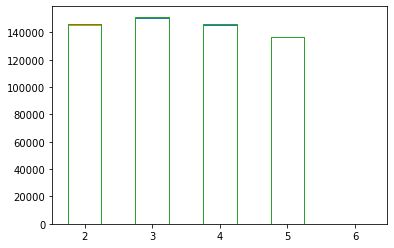

In [17]:
plt.hist( b_jet_ds.n_neighbors, bins=np.linspace(1.75,6.25,10),histtype='step')
plt.hist( c_jet_ds.n_neighbors, bins=np.linspace(1.75,6.25,10),histtype='step')
plt.hist( u_jet_ds.n_neighbors, bins=np.linspace(1.75,6.25,10),histtype='step')
plt.show()

In [18]:
batch_size = 1000
batch_sampler_bjets = JetEventsSampler(b_jet_ds.n_neighbors,batch_size)
data_loader_bjets = DataLoader(b_jet_ds,batch_sampler=batch_sampler_bjets)

batch_sampler_cjets = JetEventsSampler(c_jet_ds.n_neighbors,batch_size)
data_loader_cjets = DataLoader(c_jet_ds,batch_sampler=batch_sampler_cjets)

batch_sampler_ujets = JetEventsSampler(u_jet_ds.n_neighbors,batch_size)
data_loader_ujets = DataLoader(u_jet_ds,batch_sampler=batch_sampler_ujets)

In [19]:
class JetEfficiencyNet(nn.Module):
    def __init__(self, in_features, hidden_layers, neighbor_feats, neighbor_layer_sizes):
        
        super(JetEfficiencyNet, self).__init__()

        jet_eff_layers = []
        jet_eff_layers.append(nn.Linear(in_features,hidden_layers[0]))
        jet_eff_layers.append(nn.ReLU())
        
        for hidden_i in range(1,len(hidden_layers)):
            jet_eff_layers.append(nn.Linear(hidden_layers[hidden_i-1],hidden_layers[hidden_i]))
            jet_eff_layers.append(nn.ReLU())
        
        jet_eff_layers.append(nn.Linear(hidden_layers[-1],1))
        jet_eff_layers.append(nn.Sigmoid())
                
        self.jet_eff = nn.Sequential( *jet_eff_layers )
    
        neighbor_layers = []
        neighbor_layers.append(nn.Linear(neighbor_feats+in_features,neighbor_layer_sizes[0]))
        neighbor_layers.append(nn.ReLU())
        for hidden_i in range(1,len(neighbor_layer_sizes)):
            neighbor_layers.append(nn.Linear(neighbor_layer_sizes[hidden_i-1],neighbor_layer_sizes[hidden_i]))
            neighbor_layers.append(nn.ReLU())
        neighbor_layers.append(nn.Linear(neighbor_layer_sizes[-1],1))
        neighbor_layers.append(nn.Sigmoid())
        
        self.neighbor_eff = nn.Sequential( *neighbor_layers )
        
    def forward(self, jet_inp, neighbor_inp):
        
        B, n_neighbor, _ = neighbor_inp.shape
        
        jet_eff =  self.jet_eff(jet_inp) 
        
        block = torch.cat( (jet_inp.unsqueeze(1).repeat(1,n_neighbor,1),neighbor_inp),dim=2 )
        
        neighbor_eff =  self.neighbor_eff(block) 
        
        neighbor_correction = torch.prod(neighbor_eff,1)
        
        

        return torch.mul(jet_eff,neighbor_correction)



    


In [42]:
torch.save(b_net.state_dict(), 'b_net.pt')
torch.save(c_net.state_dict(), 'c_net.pt')
torch.save(light_net.state_dict(), 'light_net.pt')

In [20]:
b_net = JetEfficiencyNet(4,[50,50],2,[50,50])
c_net = JetEfficiencyNet(4,[50,50],2,[50,50])
light_net = JetEfficiencyNet(4,[50,50],2,[50,50])

In [136]:
#net.load_state_dict( torch.load('model.pt',map_location='cpu'))

In [137]:
# for x,dRbatch,y in data_loader_bjets:
#     output = net(x,dRbatch)
#     print(x.shape,dRbatch.shape,y.shape)
#     print(output.shape)
#     break

In [21]:
loss_vs_epoch = []

In [22]:
lossfunc = nn.BCELoss()
b_optimizer = optim.Adam(b_net.parameters(), lr=0.001)
c_optimizer = optim.Adam(c_net.parameters(), lr=0.001)
light_optimizer = optim.Adam(light_net.parameters(), lr=0.001)

In [33]:
from IPython.display import clear_output

epochs = 5
#net.train()

if len(loss_vs_epoch) == 0:
    first_epoch = 0
else:
    first_epoch = len(loss_vs_epoch)

def train_dataset(d_loader, net, optimizer):
    net.train()
    batch_losses = []
    for x,dRbatch,y in tqdm(d_loader):
        optimizer.zero_grad()
        
        output = net(x,dRbatch)
        
        loss = lossfunc(output,y)
        batch_losses.append(loss.item())
        
        loss.backward()  
        optimizer.step()
    return np.mean(batch_losses)
    
    
for epoch in range(first_epoch,first_epoch+epochs):
    
    b_loss = train_dataset(data_loader_bjets, b_net, b_optimizer)
    c_loss = train_dataset(data_loader_cjets, c_net, c_optimizer)
    light_loss = train_dataset(data_loader_ujets, light_net, light_optimizer)
    loss_vs_epoch.append([epoch,b_loss,c_loss,light_loss])
    clear_output()

    print(loss_vs_epoch[-1])
    


[30, 0.5202617618403209, 0.5246515471738007, 0.10258169787884099]


KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(np.array(loss_vs_epoch)[:,0],np.array(loss_vs_epoch)[:,1])
ax.plot(np.array(loss_vs_epoch)[:,0],np.array(loss_vs_epoch)[:,2])
ax.plot(np.array(loss_vs_epoch)[:,0],np.array(loss_vs_epoch)[:,3])
ax.set_ylim(0,1)
ax.set_xlim(0,len(loss_vs_epoch))
plt.show()

## apply the trained network to the validation sample, and compute the efficiencies

In [24]:
valid_ds = SingleJetDataset(jet_valid_data)
train_ds = SingleJetDataset(jets_train_data)

In [34]:

def eval_on_ds(net, ds):
    
    net.eval();
    indx_list = []
    predictions = []
    

    for njet_neighbors in tqdm( range(1,np.amax(ds.n_neighbors)+1) ):

        jet_indxs = np.where(ds.n_neighbors == njet_neighbors)[0]
        if len(jet_indxs) < 1:
            continue
        indx_list+=list(jet_indxs)

        input_batch = np.stack([ds[i][0] for i in jet_indxs])
        input_neighbors_batch = np.stack([ds[i][1] for i in jet_indxs])
        
        output =  net( torch.tensor( input_batch ), torch.tensor(input_neighbors_batch) ).data.numpy()

        predictions+=list( output )


    sorted_predictions = [x[0] for _, x in sorted(zip(indx_list, predictions))]
    
    return sorted_predictions

jet_valid_data['b_eff'] = eval_on_ds(b_net,valid_ds)
jet_valid_data['c_eff'] = eval_on_ds(c_net,valid_ds)
jet_valid_data['u_eff'] = eval_on_ds(light_net,valid_ds)
#sorted_predictions_training_set = eval_on_ds(ds)

In [35]:
jet_valid_data['NN_predictions'] = np.zeros(len(jet_valid_data))

jet_valid_data.loc[jet_valid_data.jet_label==1,'NN_predictions'] = jet_valid_data.loc[jet_valid_data.jet_label==1]['b_eff']
jet_valid_data.loc[jet_valid_data.jet_label==2,'NN_predictions'] = jet_valid_data.loc[jet_valid_data.jet_label==2]['c_eff']
jet_valid_data.loc[jet_valid_data.jet_label==3,'NN_predictions'] = jet_valid_data.loc[jet_valid_data.jet_label==3]['u_eff']

In [36]:
#jet_valid_data

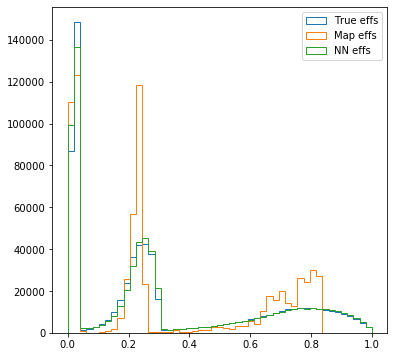

In [37]:
fig,ax = plt.subplots(figsize=(6,6))

ax.hist( jet_valid_data['jet_eff'] , bins=np.linspace(0,1,50) ,label='True effs',histtype='step')
ax.hist( jet_valid_data['map_eff'] , bins=np.linspace(0,1,50) ,label='Map effs',histtype='step')
ax.hist( jet_valid_data['NN_predictions'] , bins=np.linspace(0,1,50) ,label='NN effs',histtype='step')
ax.legend()

plt.show()

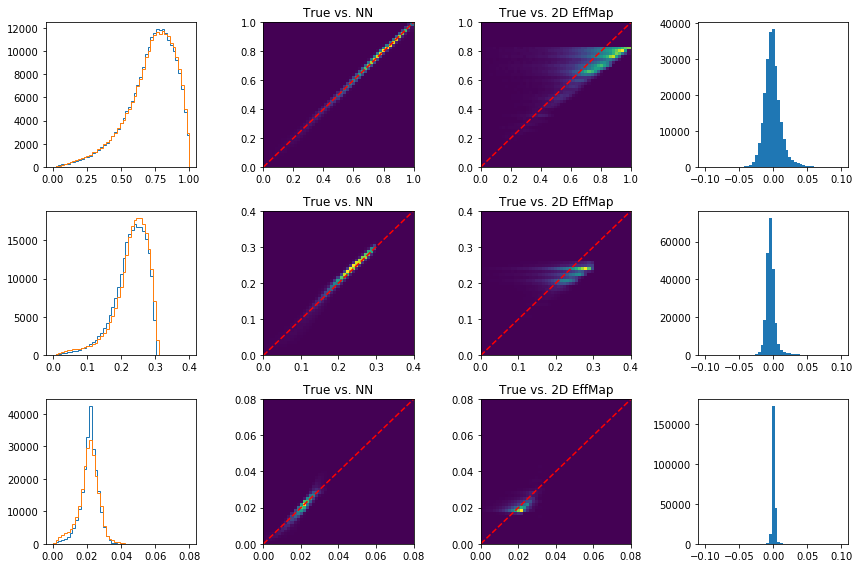

In [41]:
fig,ax = plt.subplots(3,4,figsize=(12,8))

flav_ranges = {
    1 : [0,1],
    2 : [0,0.4],
    3 : [0,0.08]
}

for flav_i,flav in enumerate([1,2,3]):
    flav_cut = jet_valid_data['jet_label'] == flav
    
    binning = np.linspace(flav_ranges[flav][0],flav_ranges[flav][1],50)
    
    ax[flav_i][0].hist( jet_valid_data['jet_eff'].loc[flav_cut] , bins=binning ,label='True effs',histtype='step')
   # ax[flav_i][0].hist( jet_valid_data['map_eff'].loc[flav_cut] , bins=binning ,label='Map effs',histtype='step')
    ax[flav_i][0].hist( jet_valid_data['NN_predictions'].loc[flav_cut] , bins=binning ,label='NN effs',histtype='step')
    #ax[flav_i][0].legend()
    ax[flav_i][1].hist2d( jet_valid_data['jet_eff'].loc[flav_cut],
                         jet_valid_data['NN_predictions'].loc[flav_cut] , 
                         bins=(binning,binning))
    ax[flav_i][1].set_title('True vs. NN')
    for i in range(1,3):
        ax[flav_i][i].plot([flav_ranges[flav][0],flav_ranges[flav][1]],
                       [flav_ranges[flav][0],flav_ranges[flav][1]],c='r',linestyle='--')
    ax[flav_i][2].set_title('True vs. 2D EffMap')
    ax[flav_i][2].hist2d( jet_valid_data['jet_eff'].loc[flav_cut],
                         jet_valid_data['map_eff'].loc[flav_cut] , 
                         bins=(binning,binning))
    ax[flav_i][3].hist( jet_valid_data['jet_eff'].loc[flav_cut]-jet_valid_data['NN_predictions'].loc[flav_cut] , 
                         bins=np.linspace(-0.1,0.1,50))

plt.tight_layout()    
plt.show()


In [163]:
def compute_event_flav(jet_dataframe):

    flav_1 = jet_dataframe.loc[ jet_dataframe['subentry'] == 0 ]['jet_label'].values
    flav_2 = jet_dataframe.loc[ jet_dataframe['subentry'] == 1 ]['jet_label'].values

    bb_locations = (flav_1 == 1) & (flav_2 == 1)
    bc_locations = ((flav_1 == 1) & (flav_2 == 2)) | ((flav_1 == 2) & (flav_2 == 1))
    bl_locations = ((flav_1 == 1) & (flav_2 == 3)) | ((flav_1 == 3) & (flav_2 == 1))
    cc_locations = (flav_1 == 2) & (flav_2 == 2)
    cl_locations = ((flav_1 == 2) & (flav_2 == 3)) | ((flav_1 == 3) & (flav_2 == 2))
    ll_locations = (flav_1 == 3) & (flav_2 == 3)
    
    event_flav = np.ones(len(flav_1)).astype(str)
    
    event_flav[bb_locations] = 'bb'
    event_flav[bc_locations] = 'bc'
    event_flav[bl_locations] = 'bl'
    event_flav[cc_locations] = 'cc'
    event_flav[cl_locations] = 'cl'
    event_flav[ll_locations] = 'll'
    
    return event_flav
    
    
event_df_valid['event_flav'] = compute_event_flav(jet_valid_data)

In [199]:
eff1 = jet_valid_data.loc[ jet_valid_data['subentry'] == 0 ]['NN_predictions'].values
eff2 = jet_valid_data.loc[ jet_valid_data['subentry'] == 1 ]['NN_predictions'].values

tt_weights_NN = {
 0: (1-eff1)*(1-eff2),
 1: (eff1)*(1-eff2)+(1-eff1)*(eff2),
 2: (eff1)*(eff2)
}

In [200]:
true_eff1 = jet_valid_data.loc[ jet_valid_data['subentry'] == 0 ]['jet_eff'].values
true_eff2 = jet_valid_data.loc[ jet_valid_data['subentry'] == 1 ]['jet_eff'].values

tt_weights_True = {
 0: (1-true_eff1)*(1-true_eff2),
 1: (true_eff1)*(1-true_eff2)+(1-true_eff1)*(true_eff2),
 2: (true_eff1)*(true_eff2)
}

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


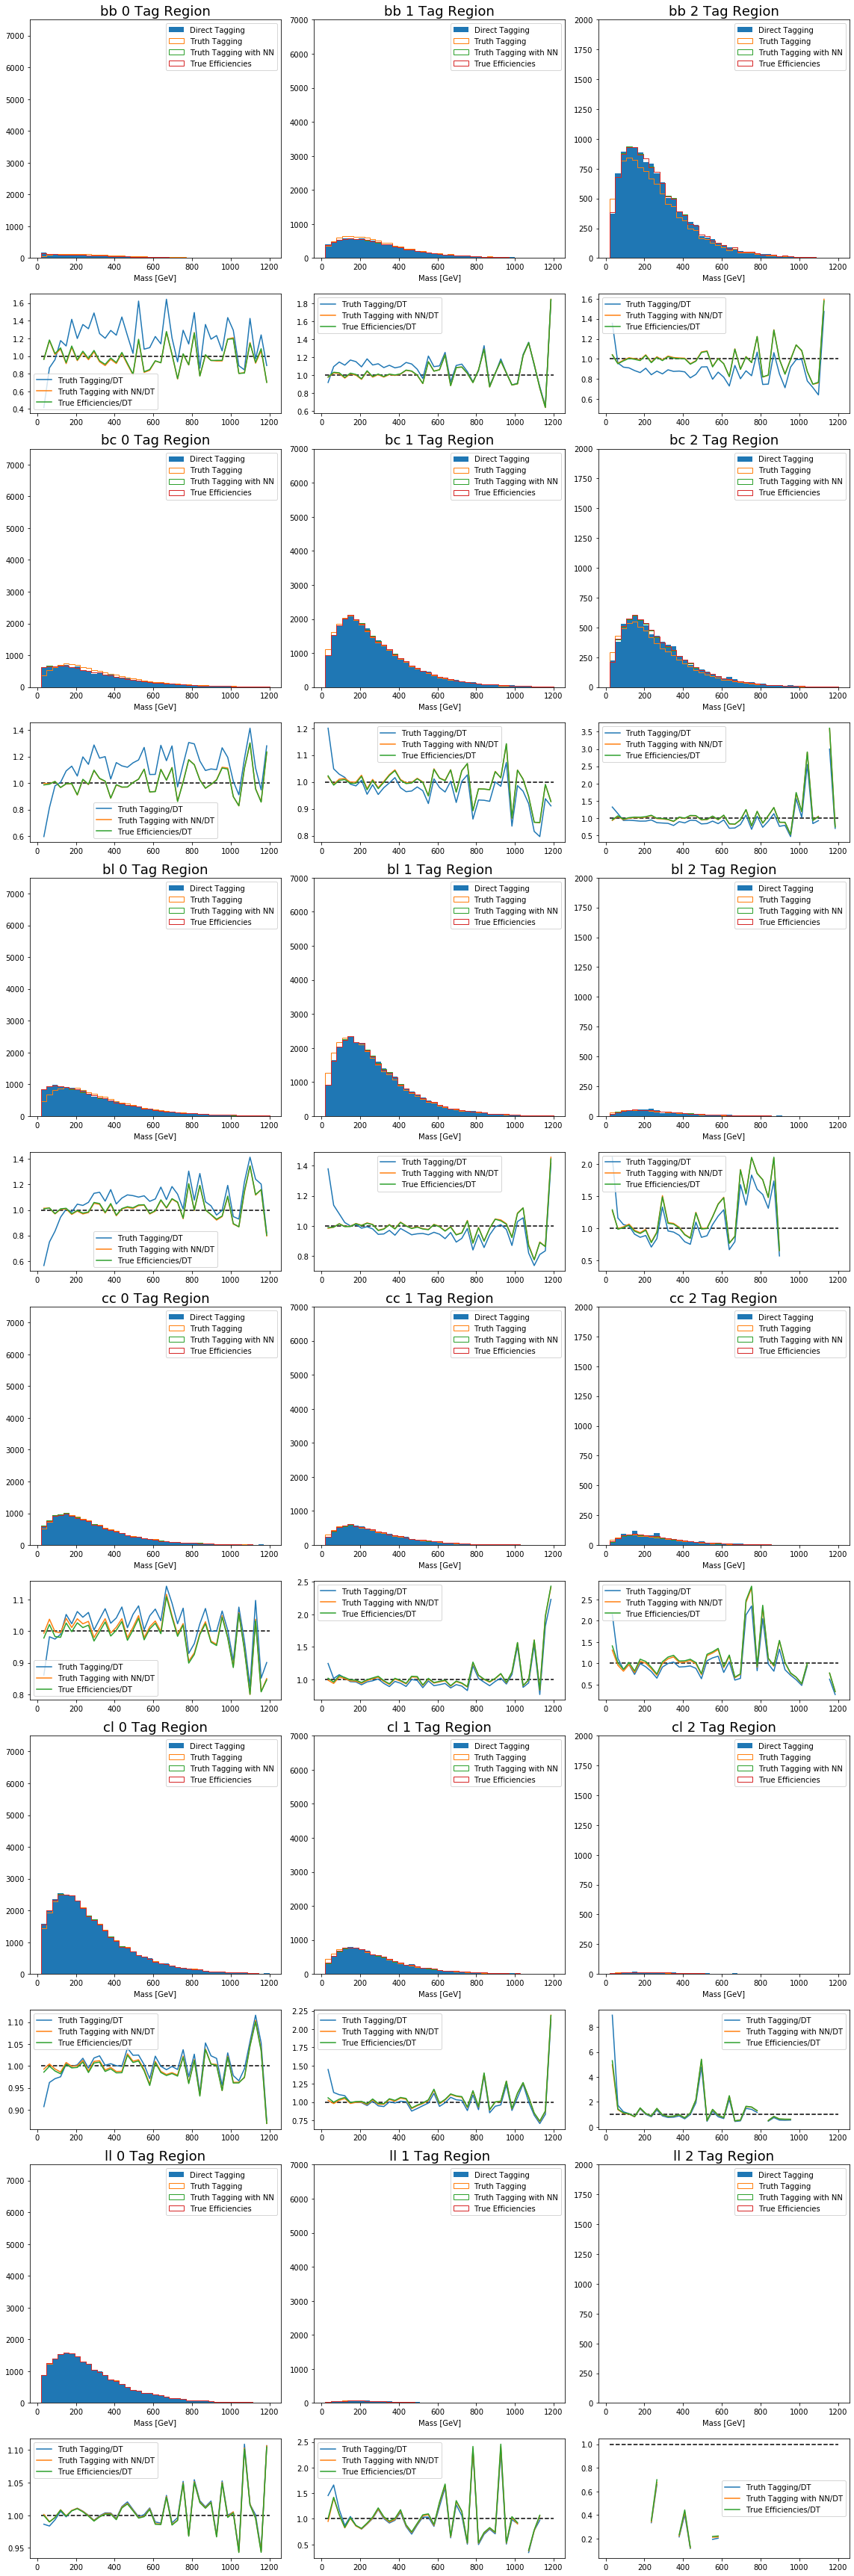

In [201]:

tt_algos = {
    'Truth Tagging' : tt_weights,
    'Truth Tagging with NN' : tt_weights_NN,
    'True Efficiencies' : tt_weights_True
}

event_flavs = [
'bb',
'bc',
'bl',
'cc',
'cl',
'll',
]
n_flavs = len(event_flavs)
n_tag_range = {
    0 : 7500,
    1 : 7000,
    2 : 2000
}

fig,ax = plt.subplots(n_flavs*2,3,figsize=(16,8*n_flavs),gridspec_kw={'height_ratios':n_flavs*[2,1]})


for plot_i, ntags in enumerate([0,1,2]):
    for event_flav_i, event_flav in enumerate( event_flavs):
        
        ax_i = ax[0+2*event_flav_i][plot_i]
        ax_j = ax[1+2*event_flav_i][plot_i]
        flav_cut = event_df_valid['event_flav'] == event_flav
        if ntags==0:
            tag_condition = (jet_1_valid_target == 0) & (jet_2_valid_target == 0)
        elif ntags==1:
            tag_condition = (((jet_1_valid_target == 1) & (jet_2_valid_target == 0)) 
                             | ((jet_1_valid_target == 0) & (jet_2_valid_target == 1)) )
        elif ntags==2:
            tag_condition = (jet_1_valid_target == 1) & (jet_2_valid_target == 1)

        mass_binning = np.linspace(20,1200,42)
        h_dt = ax_i.hist(event_df_valid['mass'].values[tag_condition & flav_cut]
                         ,bins=mass_binning,label='Direct Tagging')

        bin_centers = [(mass_binning[i+1]+mass_binning[i])/2 for i in range(len(mass_binning)-1)]
        ax_j.plot([mass_binning[0],mass_binning[-1]],[1,1],color='k',linestyle='--')
        for algo, weights_dict in tt_algos.items():

            h_tt = ax_i.hist(event_df_valid['mass'][flav_cut],weights=weights_dict[ntags][flav_cut],histtype='step',
                  bins=mass_binning,
                  label=algo)
            ax_j.plot(bin_centers,h_tt[0]/h_dt[0],label=algo+'/DT')

        
        #ax_j.set_ylim(0.7,1.3)
        ax_j.legend()
        ax_i.set_ylim(0,n_tag_range[ntags])
        ax_i.set_xlabel('Mass [GeV]')
        ax_i.set_title(event_flav+' '+str(ntags)+' Tag Region',fontsize=18)
        ax_i.legend()
plt.tight_layout()
plt.show()